# Survival Analysis On Synthesis Data for Diabetic Patients

### Project Details

This is the BYOP (bring your own project) Capstone Project for our IPBA Program from IIM Indore.

### Scope of the Project

This project aims to analyze daibetes patient's TIME ON THERAPY using advance analysis techniques.

### Objective

Main objective for this project is to provide a solution that busineses can implement to understand the patient's behaviour and different scenarios.

### Data

We have generated the simulated Anonymised Patient Level Data using the python Faker module.

| Field                     | Description                                                                   |
|:--------------------------|:------------------------------------------------------------------------------|
|: claim_id                :|: Insurance Claim Number (Unique)                                             :|
|: patient_id              :|: Patient Unique ID                                                           :|
|: service_date            :|: Date when the claim was initiated                                           :|
|: claim_type              :|: Paid, Rejected or Reversed Claim                                            :|
|: days_supply             :|: No. of Days Drugs was Supplied For                                          :|
|: quantity                :|: Quantity of Medicine(Capsules)                                              :|
|: patient_birth_year      :|: DOB of Patient                                                              :|
|: gender                  :|: Gender of Patient                                                           :|
|: diseases_type           :|: T1: Type 1 / T2: Type 2 Diabetes                                            :|
|: ndc                     :|: Product ID / Unique Durg Code                                               :|
|: drug_name               :|: Brand Name of the Drug                                                      :|
|: class                   :|: Category of Drug                                                            :|
|: sub_class               :|: Sub Category of Drug                                                        :|
|: mode_of_dispensation    :|: How drug is Dispensed - Oral or Injectible                                  :|
|: treatment_hierarchy     :|: The order in which drug is prescribed as diabetes intensifies               :|
|: past_medical_history    :|: Yes or No                                                                   :|
|: family_history          :|: Family History of Diabetes - Yes or No                                      :|
|: is_there_complication   :|: Yes or No                                                                   :|
|: marital_status          :|: Married or Unmarried                                                        :|
|: educational_status      :|: Educated or Uneducated                                                      :|
|: employee_status         :|: Employed or Unemployed                                                      :|

# Importing Libraries

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lifelines
import os
import pymysql.cursors
import warnings
warnings.filterwarnings('ignore')   # ignore warnings
from datetime import datetime
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter
from lifelines.utils import median_survival_times
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split    # split data
from lifelines.utils import restricted_mean_survival_time
from matplotlib import pyplot as plt
from lifelines.plotting import rmst_plot

In [3]:
# Filters
start_date = '2019-01-01'
end_date = '2022-12-31'

# Import Data

In [4]:
apld_df = pd.read_pickle('df_diabetes_s1.pickle')

In [5]:
apld_df.head().T

,0,1,2,3,4
claim_id,517566340,387782725,999807010,999807011,999807012
patient_id,20006,20006,20006,20006,20006
service_date,2021-10-30,2021-12-14,2022-02-12,2022-05-13,2022-05-13
claim_type,pd,pd,pd,pd,pd
days_supply,45,60,90,45,45
quantity,60,15,75,75,75
patient_birth_year,1963,1963,1963,1963,1963
gender,m,m,m,m,m
disease_type,t2,t2,t2,t2,t2
ndc,47152818127,83161652750,83161652750,83903911733,78589353539


### Filtering Relevant Data

Data Satisfying the following conditions
```
- Paid claims
- For Patients with Type 2 Diabetes
- Within Study Date Range
```

In [6]:
apld = apld_df[apld_df['claim_type'].isin(['pd'])].copy()
apld['service_date'] = pd.to_datetime(apld['service_date'])

# Type 2 Diabetes

apld = apld[apld['disease_type'].isin(['t2'])]

apld = apld[apld['service_date'].between(start_date, end_date)]

# Feature Creation

- `tot`           : time on therapy (first day supply till last day supply)
- `survived`      : whether the patient is active or not by the end of our study
- `total_time`    : time period of the study - 4 years
- `dc`            : days covered (sum(days_supply))

### Calculate Patients Age

In [7]:
# Take max birth date, as some patients have multiple birth dates
age_df = apld.groupby('patient_id').agg({'patient_birth_year': 'max'}).reset_index()
now = datetime.now()
age_df['age'] = now.year - age_df['patient_birth_year']

### Derive tot (Time on Therapy)

In [8]:
apld['drug_supply_next_date'] = apld['service_date'] + pd.to_timedelta(apld['days_supply'], unit='d')

In [9]:
tot = apld.groupby('patient_id').agg({'service_date': 'min', 'drug_supply_next_date': 'max'}).reset_index().rename(columns={'service_date': 'drug_supply_first_date', 'drug_supply_next_date': 'drug_supply_last_date'})

In [11]:
# Duplicates
tot['dup'] = tot.duplicated('patient_id', keep=False)
print(tot['dup'].value_counts())
del tot['dup']

False    9027
Name: dup, dtype: int64


In [13]:
# Deriving tot
tot['tot'] = (tot['drug_supply_last_date'] - tot['drug_supply_first_date']).dt.days
tot['total_time'] = (pd.Timestamp(end_date) - pd.Timestamp(start_date)).days

### Survival Assumption

Our Assumption is that if a patient does not take medication after the last date date of drug supply expired then the patients has `DISCONTINUED TREATMENT`. We see that in the study period (2019 to 2022) ~76% patients have discontinued or not stayed on the therapy for the complete period of the study.

In [14]:
tot['survived'] = np.where(tot['drug_supply_last_date'] <= end_date, '1', '0')

In [15]:
tot['survived'].value_counts()

1    6896
0    2131
Name: survived, dtype: int64

In [16]:
# Normalised tot
tot['survived'].value_counts(normalize=True)

1    0.76393
0    0.23607
Name: survived, dtype: float64

### Plot of overall survived

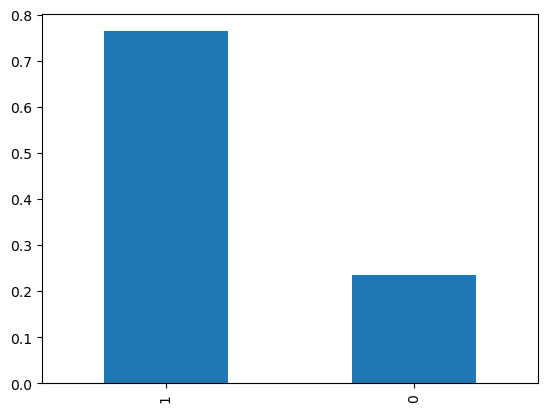

In [18]:
tot['survived'].value_counts(normalize=True).plot(kind='bar')
plt.show()

## Derive Days Covered

In [20]:
# Days Covered
dc = apld.groupby('patient_id').agg({'days_supply': 'sum'}).reset_index().rename(columns={'days_supply': 'dc'})

In [21]:
# Combine tot and dc
apld = pd.merge(apld, tot[['patient_id', 'drug_supply_first_date', 'drug_supply_last_date', 'tot', 'total_time', 'survived']], on=['patient_id'], how='left')
apld = pd.merge(apld, dc, on=['patient_id'], how='left')
apld = pd.merge(apld, age_df[['patient_id', 'age']], on=['patient_id'], how='left')

# Select Features

In [24]:
input = ['patient_id', 'gender', 'age', 'past_medical_history', 'family_history', 'is_there_complication', 'marital_status', 'educational_status', 'employee_status', 'tot', 'total_time', 'survived', 'dc']
s1_apld = apld[input].drop_duplicates()
s1_apld.head().T

,0,20,23,54,71
patient_id,20006,20021,20023,20038,20044
gender,m,f,f,m,m
age,60,62,43,43,52
past_medical_history,y,n,y,n,n
family_history,n,y,n,n,n
is_there_complication,y,y,y,n,y
marital_status,married,single,married,married,married
educational_status,educated,educated,educated,uneducated,educated
employee_status,unemployed,unemployed,unemployed,unemployed,unemployed
tot,270,112,661,495,1139


In [25]:
# Duplicate patients
s1_apld['dup'] = s1_apld.duplicated('patient_id', keep=False)
print(s1_apld['dup'].value_counts())

False    8761
True      532
Name: dup, dtype: int64


In [27]:
s1_apld[s1_apld['dup'] == True]

# Duplicate records: Gender, Past Medical History appear in 2 different catetories for the same patient

s1_apld[s1_apld['patient_id'] == 20227].T

,366,384
patient_id,20227,20227
gender,f,m
age,22,22
past_medical_history,n,y
family_history,n,n
is_there_complication,n,y
marital_status,married,single
educational_status,educated,uneducated
employee_status,employee,unemployed
tot,1318,1318


In [29]:
# Drop duplicates
dups = s1_apld[s1_apld['dup'] == 1].sort_values(by= ['patient_id'])
s1_apld = s1_apld[s1_apld['dup'] == 0]
del s1_apld['dup']

# Exploratory Data Analysis

In [34]:
# Patients within last 4 years
last4y = apld[apld['service_date'].between(start_date,end_date)][['patient_id']].drop_duplicates()
s1_apld_4_yrs = s1_apld[s1_apld['patient_id'].isin(last4y['patient_id'])].reset_index(drop=True)

In [36]:
# ~75% of the patients have left the cohort
s1_apld_4_yrs['survived'].value_counts(normalize=True)*100

1    76.829129
0    23.170871
Name: survived, dtype: float64

#### Plots : Patients Survived 

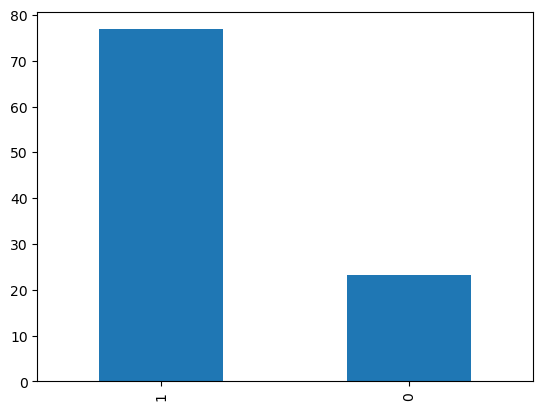

In [38]:
(s1_apld['survived'].value_counts(normalize=True)*100).plot(kind='bar')
plt.show()

In [42]:
# Summary
s1_apld_4_yrs.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_id,8761.0,60434.333295,23075.599055,20006.0,40781.0,60608.0,80449.0,99995.0
age,8761.0,40.016665,20.257153,5.0,22.0,40.0,58.0,75.0
tot,8761.0,556.623901,310.483732,15.0,315.0,489.0,761.0,1445.0
total_time,8761.0,1460.000000,0.000000,1460.0,1460.0,1460.0,1460.0,1460.0
dc,8761.0,915.244835,649.219487,15.0,405.0,765.0,1260.0,5655.0


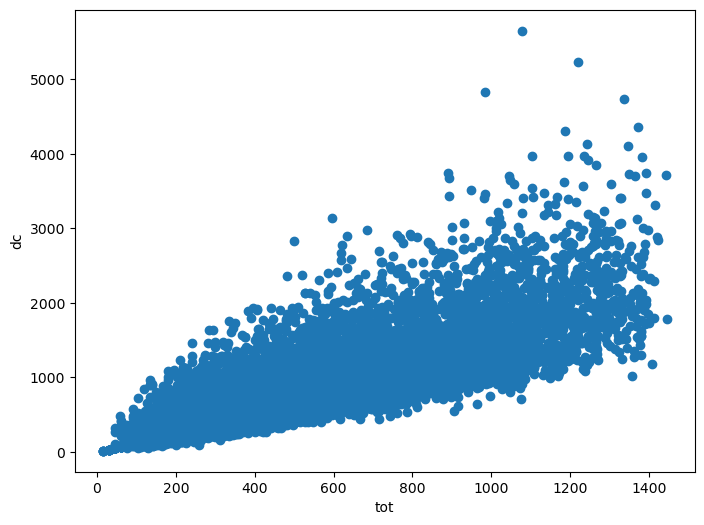

In [45]:
# Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(s1_apld_4_yrs['tot'], s1_apld_4_yrs['dc'])
plt.xlabel('tot')
plt.ylabel('dc')
plt.show()

### Plots : Patient Time on Therapy (tot)

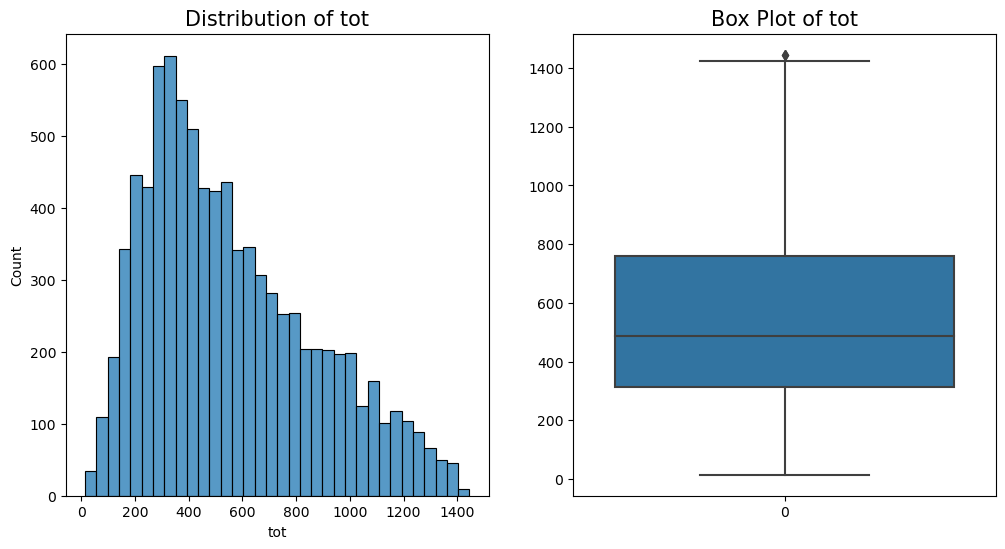

In [47]:
# Box Plot & Distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title('Distribution of tot', size = 15)
sns.histplot(s1_apld_4_yrs['tot'], ax=axes[0])
axes[1].set_title('Box Plot of tot', size = 15)    
sns.boxplot(data=s1_apld_4_yrs['tot'], ax = axes[1])
plt.show()

# Survival Analysis

Survival analysis is a statistical method for analyzing the time until an event of interest occurs, taking into account censored data and other factors that may affect the probability of the event.

In our current Analysis we are looking at the time when patient last takes thier medication signifying thier last days on diabetes therapy. 

The following termsare to be understood in contextof the current analysis:

```yaml
Event = 1            : The discontinuation of a patients therapy i.e. thier last day of drug supply is the event.
Survival Time        : Time taken till event or failure occurs or time to faliure.
Survival Probability : Probability of event occurence after a certain time.
Censor = 0           : Some patients continue their journey past the study period i.e. they did not discontinue or did not expeirence the event, they are censored.
Hazard Rate          : Opposite of Survival time, also known as event rate or death rate or failure rate.
```
<br>

<hr>

Source: https://mathworld.wolfram.com

### Survival function

$$S(t)=P( \ T \ > \ t \ ); \ 0 < t\ < \infty$$

$S(t)$ is the probability distribution of a subject surviving after time $t$ where time ranges from 0 to $\infty$.

Ideally, survival function is represented by a decreasing smooth curve which begins at $S(t) = 1$ and ends at $t = 0$. One important property of survival function is that it is monotonically decreasing.


### Hazard function
The hazard function (also known as the failure rate, hazard rate, or force of mortality) h(x) is the ratio of the probability density function P(x) to the survival function S(x), given by

$$h(x) \ = \ \frac{P(x)}{S(x)}$$

where $D(x)$ is the distribution function.

# Kaplan-Meier Estimator

In [48]:
# Patients within last 4 years
last4y = apld[apld['service_date'].between(start_date,end_date)][['patient_id']].drop_duplicates()
s1_apld_4_yrs = s1_apld[s1_apld['patient_id'].isin(last4y['patient_id'])].reset_index(drop=True)

In [49]:
# Select Variables to Model
T = s1_apld_4_yrs['tot']
E = s1_apld_4_yrs['survived']

### Model Fit

In [50]:
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 8761 total observations, 2030 right-censored observations>

### Survival Probability

In [52]:
# Survival probability
kmf.survival_function_

,KM_estimate
timeline,
0.0,1.000000
15.0,0.999429
30.0,0.998288
45.0,0.996005
59.0,0.995891
...,...
1415.0,0.064299
1421.0,0.064299
1422.0,0.064299


### Kaplan-Meier Plot

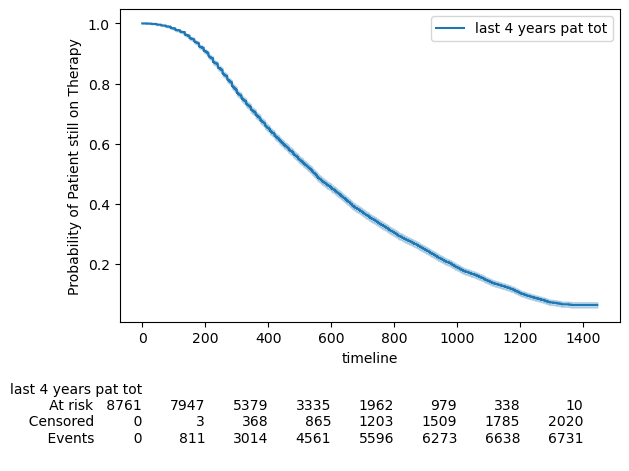

In [54]:
kmf= KaplanMeierFitter().fit(T, E, label='last 4 years pat tot')
plt.ylabel('Probability of Patient still on Therapy')
kmf.plot_survival_function(at_risk_counts=True)
plt.tight_layout()
plt.show()

# Cumulative Density

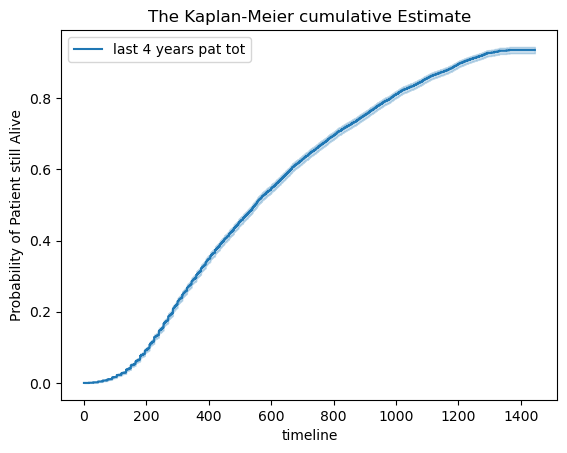

In [55]:
kmf.cumulative_density_
kmf.plot_cumulative_density()
plt.title('The Kaplan-Meier cumulative Estimate')
plt.ylabel('Probability of Patient still Alive')
plt.show()

### Event Table

In [56]:
kmf.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,8761,8761
15.0,5,5,0,0,8761
30.0,10,10,0,0,8756
45.0,20,20,0,0,8746
59.0,1,1,0,0,8726
...,...,...,...,...,...
1415.0,1,0,1,0,5
1421.0,1,0,1,0,4
1422.0,1,0,1,0,3


### Plot Confidence Interval

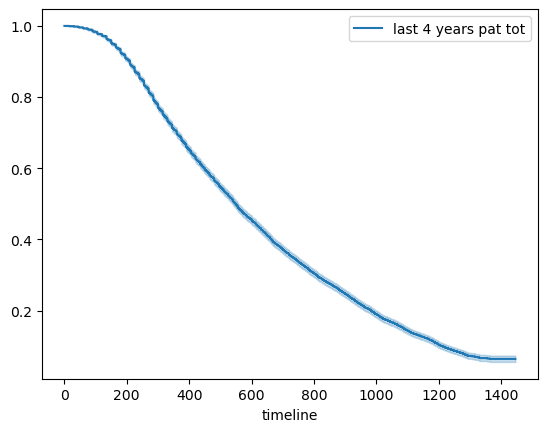

In [58]:
kmf.plot_survival_function()
plt.show()

### Median Survival Time

In [59]:
kmf.median_survival_time_

549.0

### Median Confidence Interval

In [60]:
median_ci = median_survival_times(kmf.confidence_interval_)
median_ci

,last 4 years pat tot_lower_0.95,last 4 years pat tot_upper_0.95
0.5,540.0,557.0


## Prediction

In [62]:
# Prediction: Get Survival Probability for Unknown Time Instances
kmf.predict(100)

0.9834493779248943

In [63]:
kmf.predict([10, 20, 40, 80, 160, 320, 640, 1280, 1500])

10      1.000000
20      0.999429
40      0.998288
80      0.989841
160     0.947723
320     0.747545
640     0.420211
1280    0.078316
1500    0.064299
Name: last 4 years pat tot, dtype: float64

# Compare Kaplan Meier Models

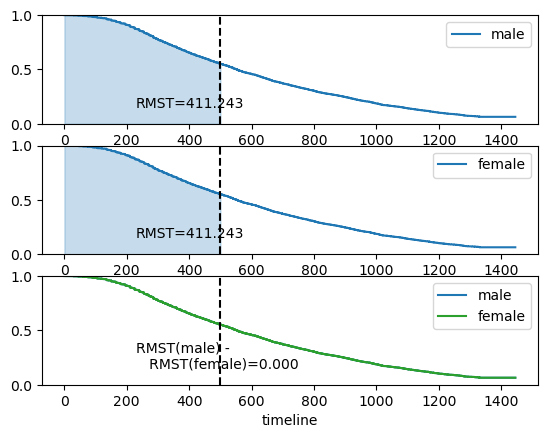

In [69]:
# Patients witthin last 4 years
last4y = apld[apld['service_date'].between(start_date, end_date)][['patient_id']].drop_duplicates()
s1_apld_4_yrs = s1_apld[s1_apld['patient_id'].isin(last4y['patient_id'])].reset_index(drop=True)
s1_apld_4_yrs.head().T

# Bins
s1_apld_4_yrs['age_bin'] = pd.cut(s1_apld_4_yrs['age'], [0, 16, 25, 45, 60, 80])

data = s1_apld_4_yrs[['tot', 'gender', 'survived']].reset_index(drop=True)

ix = data['gender'] == 'm'
T, E = data['tot'], data['survived']

time_limit = 500

kmf_male = KaplanMeierFitter().fit(T[ix], E[ix], label = 'male')
rmst_male = restricted_mean_survival_time(kmf_male, t = time_limit)

kmf_female = KaplanMeierFitter().fit(T[ix], E[ix], label = 'female')
rmst_female = restricted_mean_survival_time(kmf_female, t = time_limit)

# Plot

ax = plt.subplot(311)
rmst_plot(kmf_male, t = time_limit, ax = ax)

ax = plt.subplot(312)
rmst_plot(kmf_female, t = time_limit, ax = ax)

ax = plt.subplot(313)
rmst_plot(kmf_male, model2=kmf_female, t = time_limit, ax = ax)
plt.show()